<a href="https://colab.research.google.com/github/Galib2018/Deep-learning/blob/main/cnn_cifar10v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 !pip install tensorflow-gpu

     |████████████████████████████████| 454.3MB 37kB/s 


In [2]:
import tensorflow as tf
tf.__version__

'2.5.0'

In [2]:
 !nvidia-smi

Mon May 31 08:19:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras import regularizers, optimizers

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

#### CIFAR-10 dataset has 50,000 trainin images & 10,000 test images. Futher we divide traing dataset into 45,000 for taining and 5,000 for vlidation.

#### Preparing and split the dataset into training, validation and test set

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 6s 0us/step


In [5]:
classes = ['aeroplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [7]:
y_train_ary=y_train.reshape(-1,)
y_test_ary=y_test.reshape(-1,)

y_train_ary[0:10]

array([6, 9, 9, 4, 1, 1, 2, 7, 8, 3], dtype=uint8)

Text(0.5, 0, 'frog')

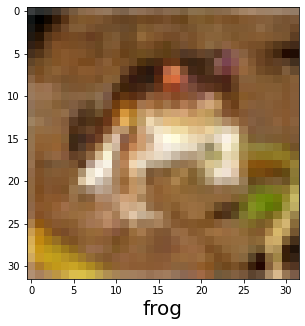

In [8]:
plt.figure(figsize=(20,5))
plt.imshow(np.squeeze(x_train[0]))
plt.xlabel(classes[y_train_ary[0]], fontsize=20)

Ploting the training images (10 samples)

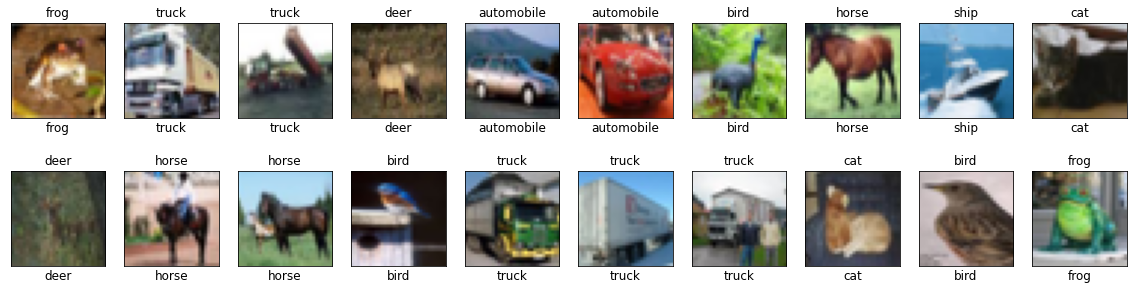

In [9]:
def plot_fig(x, y_org, y_pred, samp):
  fig = plt.figure(figsize=(20,5))
  for i in range(samp):
    ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
    ax.imshow(x[i])
    ax.set_title(classes[y_org[i]], fontsize=12)
    ax.set_xlabel(classes[y_pred[i]], fontsize=12)


plot_fig(x_train, y_train_ary, y_train_ary, samp=20)   


In [10]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

(x_train, x_valid) = x_train[5000:], x_train[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]

In [11]:
# lets print the shape of x_train, x_valid and x_test
print('Training samples:', x_train.shape)
print('validaton samples:', x_valid.shape)
print('test samples:', x_test.shape)
# format of the tuple is as: (number of instances, width, hight, channels)

Training samples: (45000, 32, 32, 3)
validaton samples: (5000, 32, 32, 3)
test samples: (10000, 32, 32, 3)


In [12]:
y_train[:5]

array([[6],
       [7],
       [9],
       [0],
       [5]], dtype=uint8)

#### Normalizing the data by substrating the mean and standard deviation from each data point 

In [13]:
mean = np.mean(x_train, axis=(0, 1, 2, 3))
std = np.std(x_train, axis=(0, 1, 2, 3))
x_train = (x_train-mean)/(std+1e-7)
x_valid = (x_valid-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

#### Labeling with One-hot encoding 

In [14]:
num_classes = 10
y_train = np_utils.to_categorical(y_train, num_classes)
y_valid = np_utils.to_categorical(y_valid, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

In [ ]:
y_train[:10]

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

#### Regulization technique: Data augmentation to avoid overfitting 

In [15]:
datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, 
                              vertical_flip=False)
datagen.fit(x_train)


#### Building model architecture

In this model we used six convlution layers and one fully connected (FC) layer. The considered Kernel size and pooling size are 3  ×  3 and 2  ×  2 respectively. "ReLu" activation function used in CNN hidden layers and "Softmax" is the out classification layer. We also included "droput" layer to aovid overfitting during the ttraing instances.

In [16]:
# Declariration of Hyperparametrs:
filters= 32
weight_decay = 1e-4  # L2 regulation hyperparameter(\lamda)
# Creates a sequential model (a linear stack of layers)
model = Sequential()

In [17]:
# CONV1
model.add(Conv2D(filters, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(weight_decay),
                input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())

# CONV2
model.add(Conv2D(filters, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

# POOL + Dropout
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))   # Dropout layer with 20% probability

# CONV3
model.add(Conv2D(filters*2, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

# CONV4
model.add(Conv2D(filters*2, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization()) 

# POOL + Dropout
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

# CONV5
model.add(Conv2D(filters*4, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

# CONV6
model.add(Conv2D(filters*4, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

# POOL + Dropout
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

# FC7
model.add(Flatten())          # Flattens the feature map into 1D feature vector
model.add(Dense(10, activation='softmax'))          # 10 hidden units because the dataset has 10 class labels.
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0

#### Training the above model 
Here, we considered loss as cross-entropy which is suitable for multiple classification problem. The optimizer algorithm Adam is used to calculate the loss. 

In [18]:
batch_size = 128   # Mini-batch size
epochs = 20       # Number of tranining interations 
checkpointer = ModelCheckpoint(filepath='model.100epochs.hdf5', verbose=1, save_best_only=True)
optimizer = keras.optimizers.RMSprop(learning_rate=0.0003, decay=1e-6)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), callbacks=[checkpointer],
                             steps_per_epoch=x_train.shape[0] // batch_size, epochs=epochs, verbose=2,
                             validation_data=(x_test, y_test))

Epoch 1/20
351/351 - 427s - loss: 2.2961 - accuracy: 0.3398 - val_loss: 1.8552 - val_accuracy: 0.3401

Epoch 00001: val_loss improved from inf to 1.85525, saving model to model.100epochs.hdf5
Epoch 2/20
351/351 - 408s - loss: 1.6457 - accuracy: 0.4650 - val_loss: 1.4216 - val_accuracy: 0.5282

Epoch 00002: val_loss improved from 1.85525 to 1.42161, saving model to model.100epochs.hdf5
Epoch 3/20
351/351 - 406s - loss: 1.4237 - accuracy: 0.5313 - val_loss: 1.2215 - val_accuracy: 0.5959

Epoch 00003: val_loss improved from 1.42161 to 1.22150, saving model to model.100epochs.hdf5
Epoch 4/20
351/351 - 414s - loss: 1.2906 - accuracy: 0.5789 - val_loss: 1.3618 - val_accuracy: 0.5805

Epoch 00004: val_loss did not improve from 1.22150
Epoch 5/20
351/351 - 410s - loss: 1.1889 - accuracy: 0.6106 - val_loss: 1.1536 - val_accuracy: 0.6299

Epoch 00005: val_loss improved from 1.22150 to 1.15362, saving model to model.100epochs.hdf5
Epoch 6/20
351/351 - 404s - loss: 1.0988 - accuracy: 0.6408 - val_

In [19]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

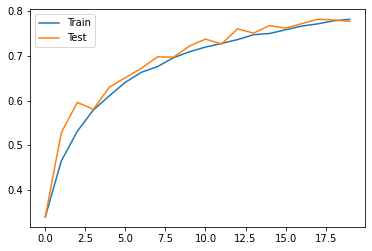

In [20]:
# plot learning curves
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.legend()
plt.show()

Model Evaluation

In [21]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 20s 65ms/step - loss: 0.7495 - accuracy: 0.7770


[0.7494522333145142, 0.7770000100135803]

Loss curves 


Text(0.5, 1.0, 'Loss Curves')

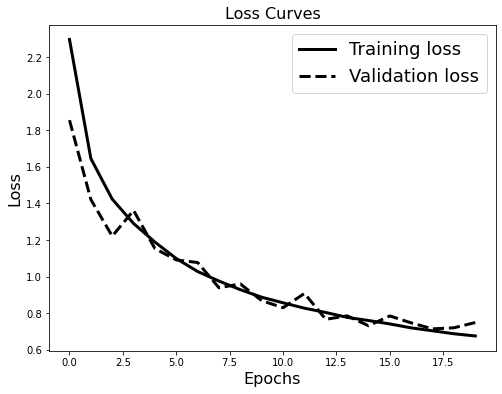

In [23]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'], 'black', linewidth=3.0)
plt.plot(history.history['val_loss'], 'black', ls = '--', linewidth=3.0)
plt.legend(['Training loss', 'Validation loss'], fontsize=18)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Loss Curves', fontsize=16)

Ploting the test samples 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

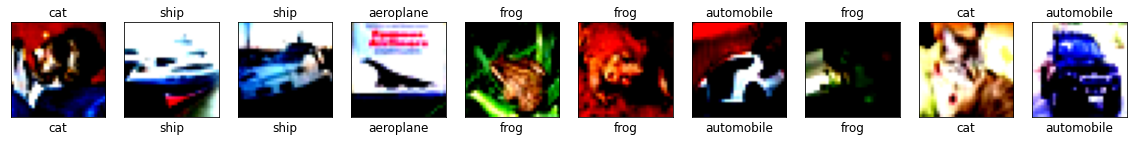

In [25]:
plot_fig(x_test, y_test_ary, y_test_ary, samp=10)

Prediction of test samples 

In [26]:
y_pred = model.predict(x_test)
y_pred[:5]

array([[9.94733418e-04, 1.61868501e-02, 4.53019311e-04, 5.82174480e-01,
        3.78191192e-03, 1.30706374e-02, 2.92652939e-02, 1.79399649e-04,
        3.44486773e-01, 9.40695498e-03],
       [5.89154433e-06, 5.56105329e-03, 2.01757638e-10, 3.87064297e-10,
        1.56770985e-10, 4.66539220e-12, 3.58855085e-10, 2.72276472e-11,
        9.94421065e-01, 1.19945425e-05],
       [1.11162011e-03, 1.59471065e-01, 1.70489311e-05, 1.36801714e-06,
        4.73682348e-06, 5.20728136e-08, 9.90838089e-06, 9.78338107e-07,
        8.36326420e-01, 3.05681420e-03],
       [7.37170696e-01, 6.49868743e-03, 3.27031565e-04, 8.91745149e-05,
        2.29898360e-05, 6.72233455e-07, 1.75159166e-05, 8.44488295e-06,
        2.44078040e-01, 1.17866965e-02],
       [3.34172523e-06, 1.26665094e-04, 2.16615740e-02, 8.12422717e-04,
        1.88601807e-01, 4.93964035e-06, 7.88738668e-01, 3.85184512e-06,
        1.70416861e-05, 2.96479338e-05]], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

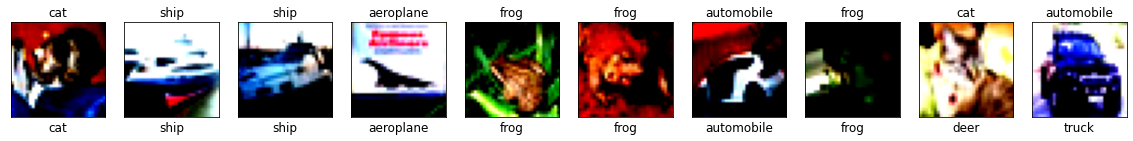

In [27]:
y_pred_classes = [np.argmax(element) for element in y_pred]
y_pred_classes[:5]

plot_fig(x_test, y_test_ary, y_pred_classes, samp=10)